In [108]:
import pandas as pd
import numpy as np
import locale
import glob
import os.path
import requests
import tarfile

import pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [ ]:
"""inspired by:
https://gist.github.com/zacstewart/5978000
https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-IMDB.ipynb

data description:
http://ai.stanford.edu/~amaas/data/sentiment/
"""

In [10]:
dirname = '../data/aclImdb'
filename = '../data/aclImdb_v1.tar.gz'
locale.setlocale(locale.LC_ALL, 'C')


# Convert text to lower-case and strip punctuation/symbols from words
def normalize_text(text):
    norm_text = text.lower()

    # Replace breaks with spaces
    norm_text = norm_text.replace('<br />', ' ')

    # Pad punctuation with spaces on both sides
    for char in ['.', '"', ',', '(', ')', '!', '?', ';', ':']:
        norm_text = norm_text.replace(char, ' ' + char + ' ')

    return norm_text


def collect_reviews(dirname):
    if not os.path.isdir(dirname):
        if not os.path.isfile(filename):
            print("file 'alldata-id.txt' not found; downloading")
            # Download IMDB archive
            url = 'http://ai.stanford.edu/~amaas/data/sentiment/' + filename
            r = requests.get(url)
            with open(filename, 'wb') as f:
                f.write(r.content)

        tar = tarfile.open(filename, mode='r')
        tar.extractall()
        tar.close()

    # Concat and normalize test/train data
    folders = ['train/pos', 'train/neg', 'test/pos', 'test/neg', 'train/unsup']
    #     alldata = u''
    alldata = []

    for fol in folders:

        print(fol)
        temp = u''
        output = fol.replace('/', '-') + '.txt'

        # Is there a better pattern to use?
        txt_files = glob.glob('/'.join([dirname, fol, '*.txt']))

        for txtfi in txt_files:
            with open(txtfi, 'r', encoding='utf-8') as t:
                control_chars = [chr(0x85)]
                t_clean = t.read()

                for c in control_chars:
                    t_clean = t_clean.replace(c, ' ')

            id_, stars_ = os.path.basename(txtfi).replace(".txt", "").split("_")
            dset, judgement = fol.split("/")
            alldata.append( 
                (dset, judgement, id_, stars_, normalize_text(t_clean) )
                )

train/pos
train/neg
test/pos
test/neg
train/unsup


In [124]:
all_reviews_file = "all_reviews.tab"

if not os.path.isfile(all_reviews_file):
    alldatadf = pd.DataFrame(alldata,
                 columns = ("dataset", "judgement", "internal_id", "stars", "review" )
                )
    alldatadf.index.name = "id"
    alldatadf.to_csv(all_reviews_file, sep="\t")
else:
    alldatadf = pd.read_table(all_reviews_file, index_col=[0])

In [125]:
alldatadf[:5]

,dataset,judgement,internal_id,stars,review
id,,,,,
0,train,pos,0,9,bromwell high is a cartoon comedy . it ran at...
1,train,pos,10000,8,homelessness ( or houselessness as george car...
2,train,pos,10001,10,brilliant over-acting by lesley ann warren . ...
3,train,pos,10002,7,this is easily the most underrated film inn th...
4,train,pos,10003,8,this is not the typical mel brooks film . it ...


In [126]:
alldatadf["stars"].value_counts()

0     50000
1     10122
10     9731
8      5859
4      5331
3      4961
7      4803
9      4607
2      4586
Name: stars, dtype: int64

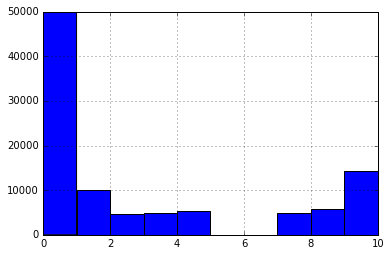

In [128]:
alldatadf["stars"].hist()

In [129]:
alldatadf.groupby(["judgement", "dataset"]).agg("count")

internal_id  stars  review
judgement dataset                            
neg       test           12500  12500   12500
          train          12500  12500   12500
pos       test           12500  12500   12500
          train          12500  12500   12500
unsup     train          50000  50000   50000

In [131]:
alldatadf.groupby(["judgement", "dataset"]).agg(np.mean)["stars"]

judgement  dataset
neg        test       2.22312
           train      2.21696
pos        test       8.80280
           train      8.73848
unsup      train      0.00000
Name: stars, dtype: float64

In [132]:
alldatadf.groupby(["dataset"]).agg(np.mean)["stars"]

dataset
test     5.512960
train    1.825907
Name: stars, dtype: float64

In [133]:
alldatadf[alldatadf["judgement"]!="unsup"].groupby(["dataset"]).agg(np.mean)["stars"]

dataset
test     5.51296
train    5.47772
Name: stars, dtype: float64

In [22]:
"remove unsupervised data points"
alldatadf = alldatadf[(alldatadf["judgement"]!="unsup")]

In [24]:
"replace textual judgement label by a binary/boolean label"
alldatadf["positive_judgement"] = alldatadf["judgement"] == "pos"
alldatadf.drop("judgement", axis=1, inplace=True)

In [30]:
train_data = alldatadf[(alldatadf["dataset"] == "train")]
train_data.drop("dataset", axis=1, inplace=True)
# del alldatadf

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [105]:
ngrams = vect.fit_transform(train_data[:20].review.as_matrix())
np.asarray(ngrams)

NameError: name 'np' is not defined

In [88]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer
# from nltk.tokenize import TreebankWordTokenizer
from sklearn.utils import shuffle

ngram_size = 3
vectorizer = CountVectorizer(ngram_range=(1, ngram_size), )
# tokenizer=TreebankWordTokenizer().tokenize)

pipeline = Pipeline([
    ('count_vectorizer',   vectorizer),
    ('classifier',         MultinomialNB()),
])

In [102]:
num_points = 500
# y = train_data[:num_points]["stars"].as_matrix()
y = shuffle(train_data["positive_judgement"])[:num_points]#.as_matrix()
X = train_data.loc[y.index.tolist()]["review"].as_matrix()
# ngrams = vect.fit_transform(X)
# KFold

In [104]:
from sklearn import cross_validation
cross_validation.cross_val_score(pipeline, X, y, cv= 5, scoring="roc_auc")

array([ 0.90757457,  0.80048077,  0.86458333,  0.76903045,  0.84620098])